In [9]:
import numpy as np
import pandas as pd
import itertools
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from joblib import dump, load
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.datasets import CIFAR10, GTSRB, MNIST, FashionMNIST, CIFAR100, ImageFolder, SVHN
import torchvision.transforms as transforms

from IPython.display import clear_output

import torchbnn as bnn
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
%matplotlib inline

from methods_collection.utils.metrics_utils import auc_and_fpr_recall, acc

from methods_collection.ebo.RuntimeMonitor import EboMonitor
from networks import GtsrbAnnModel, ResNet18_32x32, Cifar10AnnModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
config = {}
config['resnet'] = {'threshold': 8.2}
config['cifar10'] = {'threshold': 14.0}
config['gtsrb'] = {'threshold': 3.5}
config['cifar_10_ann_model_mon_gan'] = {'threshold': 100.0}

## Aux functions

In [3]:
class Convert:
    def __init__(self, mode='RGB'):
        self.mode = mode

    def __call__(self, image):
        return image.convert(self.mode)

In [4]:
def plot_roc_curve(true_y, y_prob):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [5]:
def compute_all_metrics(result_in, result_out, odin_th):
  conf_in, pred_in, lab_in = result_in
  conf_out, pred_out, lab_out = result_out
  lab_out = -1 * np.ones_like(lab_out)

  conf = np.concatenate([conf_in, conf_out])
  y_pred = np.concatenate([pred_in, pred_out])
  y_true = np.concatenate([lab_in, lab_out])

  recall = 0.95
  auroc, aupr_in, aupr_out, fpr = auc_and_fpr_recall(conf, y_true, recall)

  accuracy = acc(y_pred, y_true)

  lab_true = np.zeros_like(y_true)
  lab_true[y_true == -1] = 1
  lab_pred = np.zeros_like(y_true)
  lab_pred[conf<=odin_th] = 1

  tn, fp, fn, tp = confusion_matrix(lab_true, lab_pred).ravel()
  results = [np.round(auroc*100, 2), np.round(fpr*100, 2), np.round(aupr_out*100, 2), tn, fp, fn, tp]
  return results

In [6]:
def evaluate_ood(model, ood_monitor, dataset_name, train=False):
  batch_size = 128
  dataset, test_dataset, transform = load_dataset(dataset_name)

  set_loader = DataLoader(dataset, batch_size, num_workers=2) if train else DataLoader(test_dataset, batch_size, num_workers=2)

  all_pred = []
  all_conf = []
  all_lab = []
  valCorrect = 0
  for data, target in set_loader:
        (x, y) = (data.to(device), target.to(device))
        x.requires_grad = True
        pred_values, conf = ood_monitor.process_input(model, x)

        valCorrect += torch.sum(pred_values == y).cpu()

        all_pred += pred_values.detach().cpu().numpy().tolist()
        all_conf += conf.detach().cpu().numpy().tolist()
        all_lab += y.detach().cpu().numpy().tolist()
  all_conf = np.array(all_conf)
  all_pred = np.array(all_pred)
  all_lab = np.array(all_lab)

  print(f'Accuracy: {np.round(valCorrect * 100 / len(set_loader.dataset), 2)}')

  return all_conf, all_pred, all_lab

In [7]:
def evaluate_ood_gaussian(model, ood_monitor, data_size=10000):
  batch_size = 200
  num_batches = int(data_size/batch_size)

  all_conf = []
  all_pred = []
  all_lab = []
  for i in range(num_batches):
    gaussian_noise = torch.randn(size=(batch_size, 3, 32, 32)).to(device) #+ torch.ones(size=(batch_size, 3, 32, 32)).to(device) * 0.5
    gaussian_noise.requires_grad = True
    pred_values, conf = ood_monitor.process_input(model, gaussian_noise)
    all_pred += pred_values.detach().cpu().numpy().tolist()
    all_conf += conf.detach().cpu().numpy().tolist()
    all_lab += -1 * np.ones(data_size).tolist()


  all_conf = np.array(all_conf)
  all_pred = np.array(all_pred)
  all_lab = np.array(all_lab)

  return all_conf, all_pred, all_lab

## Model loading

In [15]:
cifar10_model = Cifar10AnnModel().to(device)
cifar10_model.load_state_dict(torch.load('./models/cifar_10_ann_model/model/model.pth'))
cifar10_model.eval()

cifar_10_ann_model_mon_gan = Cifar10AnnModel().to(device)
cifar_10_ann_model_mon_gan.load_state_dict(torch.load('./models/cifar_10_ann_model_mon_gan/model/model.pth'))
cifar_10_ann_model_mon_gan.eval()

resnet = ResNet18_32x32(num_classes=10).to(device)
resnet.load_state_dict(
    torch.load('./models/cifar10_resnet18_32x32_base_e100_lr0.1_default/s0/best.ckpt', map_location=torch.device('cpu'))
)
resnet.eval()

gtsrb_model = GtsrbAnnModel().to(device)
gtsrb_model.load_state_dict(torch.load('./models/gtsrb_ann_model/model/model.pth'))
gtsrb_model.eval()

GtsrbAnnModel(
  (conv_net): Sequential(
    (0): Conv2d(3, 40, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(40, 20, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (linear1): Linear(in_features=500, out_features=240, bias=True)
  (batchnorm1): LayerNorm((240,), eps=1e-05, elementwise_affine=True)
  (activation1): ReLU()
  (linear2): Linear(in_features=240, out_features=84, bias=True)
  (batchnorm2): LayerNorm((84,), eps=1e-05, elementwise_affine=True)
  (activation2): ReLU()
  (linear3): Linear(in_features=84, out_features=43, bias=True)
  (activation3): Softmax(dim=1)
)

# CIFAR10 model evaluation

## Dataset loading

In [14]:
def load_dataset(DATASET_TO_USE):
  dataset = None
  test_dataset = None
  transform = transforms.Compose([
      Convert('RGB'),
      transforms.Resize([32, 32], interpolation=transforms.InterpolationMode.BILINEAR),
      transforms.CenterCrop(32),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
      ])
  if DATASET_TO_USE == 'CIFAR10':
    root_dataset_path = './datasets/cifar10/'
    dataset = CIFAR10(root=root_dataset_path, download=False, transform=transform)
    test_dataset = CIFAR10(root=root_dataset_path, train=False, transform=transform)
  if DATASET_TO_USE == 'GTSRB':
    root_dataset_path = './datasets/'
    dataset = GTSRB(root='./datasets/', download=False, split='train', transform=transform)
    test_dataset = GTSRB(root='./datasets/', download=False, split='test',transform=transform)
  if DATASET_TO_USE == 'MNIST':
    root_dataset_path = './datasets/mnist/'
    dataset = MNIST(root=root_dataset_path, download=False, transform=transform)
    test_dataset = MNIST(root=root_dataset_path, train=False, transform=transform)
  if DATASET_TO_USE == 'FashionMNIST':
    root_dataset_path = './datasets/fashion_mnist/'
    dataset = FashionMNIST(root=root_dataset_path, train=True, download=False, transform=transform)
    test_dataset = FashionMNIST(root=root_dataset_path, train=False, download=False, transform=transform)
  if DATASET_TO_USE == 'CIFAR100':
    root_dataset_path = './datasets/cifar100/'
    dataset = CIFAR100(root=root_dataset_path, download=True, transform=transform)
    test_dataset = CIFAR100(root=root_dataset_path, train=False, transform=transform)
  if DATASET_TO_USE == 'IMAGENET':
    dataset = ImageFolder(root='./datasets/Imagenet_resize/',  transform=transform)
    test_dataset = ImageFolder(root='./datasets/Imagenet_resize/',  transform=transform)
  if DATASET_TO_USE == 'SVHN':
    root_dataset_path = './datasets/svhn/'
    dataset = SVHN(root=root_dataset_path, split='train', download=True, transform=transform)
    test_dataset = SVHN(root=root_dataset_path, split='test', download=True, transform=transform)

  return dataset, test_dataset, transform

## Monitor tuning

In [ ]:
cifar10_ebo_monitor = EboMonitor(1000.0)

In [ ]:
all_conf_in, all_pred_in, _ = evaluate_ood(cifar_10_ann_model_mon_gan, cifar10_ebo_monitor, 'CIFAR10', True)

Accuracy: 89.62999725341797


37736


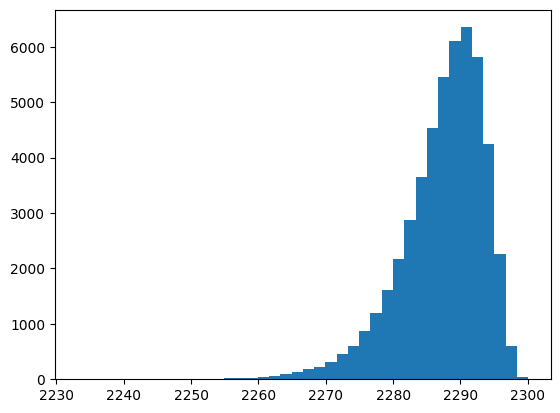

In [ ]:
print(np.sum(all_conf_in>2284))
plt.hist(all_conf_in, bins = 40)
plt.show()

In [ ]:
all_conf_out, all_pred_out, _ = evaluate_ood_gaussian(cifar_10_ann_model_mon_gan, cifar10_ebo_monitor, 50000)

38514


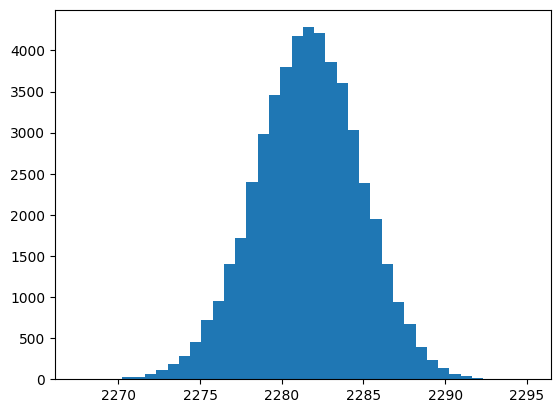

In [ ]:
print(np.sum(all_conf_out<=2284))
plt.hist(all_conf_out, bins = 40)
plt.show()

## Model evaluation

ResNet

In [12]:
results_resnet = {}
resnet_ebo_monitor = EboMonitor(1.0)

In [17]:
evaluate_ood(resnet, resnet_ebo_monitor, 'CIFAR10', True)

Accuracy: 100.0


(array([2.46112967, 2.4611342 , 2.46104431, ..., 2.46113062, 2.4611311 ,
        2.46101308]),
 array([6, 9, 9, ..., 9, 1, 1]),
 array([6, 9, 9, ..., 9, 1, 1]))

In [18]:
results_resnet['in'] = evaluate_ood(resnet, resnet_ebo_monitor, 'CIFAR10')
results_resnet['out_cifar100'] = evaluate_ood(resnet, resnet_ebo_monitor, 'CIFAR100')
results_resnet['out_image_net'] = evaluate_ood(resnet, resnet_ebo_monitor, 'IMAGENET')
results_resnet['out_svhn'] = evaluate_ood(resnet, resnet_ebo_monitor, 'SVHN')

Accuracy: 95.16999816894531
Files already downloaded and verified
Accuracy: 1.0499999523162842
Accuracy: 11.279999732971191
Using downloaded and verified file: ./datasets/svhn/train_32x32.mat
Using downloaded and verified file: ./datasets/svhn/test_32x32.mat
Accuracy: 10.4399995803833


In [ ]:
result1 = compute_all_metrics(results_resnet['in'], results_resnet['out_cifar100'], config['resnet']['threshold'])
result2 = compute_all_metrics(results_resnet['in'], results_resnet['out_image_net'], config['resnet']['threshold'])
result3 = compute_all_metrics(results_resnet['in'], results_resnet['out_svhn'], config['resnet']['threshold'])

print(['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp'])
result1_string = ''
for r in result1:
 result1_string += '$'+str(r)+'$' + " & "
print(result1_string)

result2_string = ''
for r in result2:
 result2_string +='$'+str(r)+'$' + " & "
print(result2_string)

result3_string = ''
for r in result3:
 result3_string += '$'+str(r)+'$' + " & "
print(result3_string)

['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp']
$85.49$ & $72.95$ & $86.21$ & $8036$ & $1964$ & $2017$ & $7983$ & 
$92.04$ & $38.92$ & $92.16$ & $8036$ & $1964$ & $927$ & $9073$ & 
$91.88$ & $31.6$ & $95.9$ & $8036$ & $1964$ & $2313$ & $23719$ & 


CifarAnnModel

In [ ]:
results_cifar10 = {}
cifar10_ebo_monitor = EboMonitor(1.0)

In [ ]:
results_cifar10['in'] = evaluate_ood(cifar10_model, cifar10_ebo_monitor, 'CIFAR10')
results_cifar10['out_cifar100'] = evaluate_ood(cifar10_model, cifar10_ebo_monitor, 'CIFAR100')
results_cifar10['out_image_net'] = evaluate_ood(cifar10_model, cifar10_ebo_monitor, 'IMAGENET')
results_cifar10['out_svhn'] = evaluate_ood(cifar10_model, cifar10_ebo_monitor, 'SVHN')

Accuracy: 73.58999633789062
Files already downloaded and verified
Accuracy: 0.9200000166893005
Accuracy: 6.380000114440918
Using downloaded and verified file: ./datasets/svhn/train_32x32.mat
Using downloaded and verified file: ./datasets/svhn/test_32x32.mat
Accuracy: 10.829999923706055


In [ ]:
result1 = compute_all_metrics(results_cifar10['in'], results_cifar10['out_cifar100'], config['cifar10']['threshold'])
result2 = compute_all_metrics(results_cifar10['in'], results_cifar10['out_image_net'], config['cifar10']['threshold'])
result3 = compute_all_metrics(results_cifar10['in'], results_cifar10['out_svhn'], config['cifar10']['threshold'])

print(['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp'])
result1_string = ''
for r in result1:
 result1_string += '$'+str(r)+'$' + " & "
print(result1_string)

result2_string = ''
for r in result2:
 result2_string += '$'+str(r)+'$' + " & "
print(result2_string)

result3_string = ''
for r in result3:
 result3_string += '$'+str(r)+'$' + " & "
print(result3_string)

['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp']
$70.04$ & $76.41$ & $66.3$ & $9555$ & $445$ & $8725$ & $1275$ & 
$38.55$ & $99.92$ & $44.81$ & $9555$ & $445$ & $9562$ & $438$ & 
$78.75$ & $57.88$ & $86.9$ & $9555$ & $445$ & $21947$ & $4085$ & 


cifar_10_ann_model_mon_gan

In [ ]:
results_cifar_10_ann_model_mon_gan = {}
cifar_10_ann_model_mon_gan_ebo_monitor = EboMonitor(1.0)

In [ ]:
results_cifar_10_ann_model_mon_gan['in'] = evaluate_ood(cifar_10_ann_model_mon_gan, cifar_10_ann_model_mon_gan_ebo_monitor, 'CIFAR10')
results_cifar_10_ann_model_mon_gan['out_cifar100'] = evaluate_ood(cifar_10_ann_model_mon_gan, cifar_10_ann_model_mon_gan_ebo_monitor, 'CIFAR100')
results_cifar_10_ann_model_mon_gan['out_image_net'] = evaluate_ood(cifar_10_ann_model_mon_gan, cifar_10_ann_model_mon_gan_ebo_monitor, 'IMAGENET')
results_cifar_10_ann_model_mon_gan['out_svhn'] = evaluate_ood(cifar_10_ann_model_mon_gan, cifar_10_ann_model_mon_gan_ebo_monitor, 'SVHN')

Accuracy: 73.43000030517578
Files already downloaded and verified
Accuracy: 0.9399999976158142
Accuracy: 6.210000038146973
Using downloaded and verified file: ./datasets/svhn/train_32x32.mat
Using downloaded and verified file: ./datasets/svhn/test_32x32.mat
Accuracy: 9.569999694824219


In [ ]:
result1 = compute_all_metrics(results_cifar_10_ann_model_mon_gan['in'], results_cifar_10_ann_model_mon_gan['out_cifar100'], config['cifar_10_ann_model_mon_gan']['threshold'])
result2 = compute_all_metrics(results_cifar_10_ann_model_mon_gan['in'], results_cifar_10_ann_model_mon_gan['out_image_net'], config['cifar_10_ann_model_mon_gan']['threshold'])
result3 = compute_all_metrics(results_cifar_10_ann_model_mon_gan['in'], results_cifar_10_ann_model_mon_gan['out_svhn'], config['cifar_10_ann_model_mon_gan']['threshold'])

print(['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp'])
result1_string = ''
for r in result1:
 result1_string += '$'+str(r)+'$' + " & "
print(result1_string)

result2_string = ''
for r in result2:
 result2_string += '$'+str(r)+'$' + " & "
print(result2_string)

result3_string = ''
for r in result3:
 result3_string += '$'+str(r)+'$' + " & "
print(result3_string)


['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp']
$71.81$ & $71.78$ & $67.03$ & $0$ & $10000$ & $0$ & $10000$ & 
$46.06$ & $99.44$ & $51.0$ & $0$ & $10000$ & $2$ & $9998$ & 
$81.05$ & $52.6$ & $87.7$ & $0$ & $10000$ & $0$ & $26032$ & 


GtsrbAnnModel

In [ ]:
results_gtsrb = {}
gtsrb_ebo_monitor = EboMonitor(1.0)

In [ ]:
results_gtsrb['in'] = evaluate_ood(gtsrb_model, gtsrb_ebo_monitor, 'GTSRB')
results_gtsrb['out_cifar100'] = evaluate_ood(gtsrb_model, gtsrb_ebo_monitor, 'CIFAR100')
results_gtsrb['out_image_net'] = evaluate_ood(gtsrb_model, gtsrb_ebo_monitor, 'IMAGENET')
results_gtsrb['out_svhn'] = evaluate_ood(gtsrb_model, gtsrb_ebo_monitor, 'SVHN')

Accuracy: 87.33000183105469
Files already downloaded and verified
Accuracy: 0.8399999737739563
Accuracy: 0.0
Using downloaded and verified file: ./datasets/svhn/train_32x32.mat
Using downloaded and verified file: ./datasets/svhn/test_32x32.mat
Accuracy: 1.6100000143051147


In [ ]:
result1 = compute_all_metrics(results_gtsrb['in'], results_gtsrb['out_cifar100'], config['gtsrb']['threshold'])
result2 = compute_all_metrics(results_gtsrb['in'], results_gtsrb['out_image_net'], config['gtsrb']['threshold'])
result3 = compute_all_metrics(results_gtsrb['in'], results_gtsrb['out_svhn'], config['gtsrb']['threshold'])

print(['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp'])
result1_string = ''
for r in result1:
 result1_string += '$'+str(r)+'$' + " & "
print(result1_string)

result2_string = ''
for r in result2:
 result2_string += '$'+str(r)+'$' + " & "
print(result2_string)

result3_string = ''
for r in result3:
 result3_string += '$'+str(r)+'$' + " & "
print(result3_string)

['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp']
$94.42$ & $21.14$ & $91.27$ & $11613$ & $1017$ & $1989$ & $8011$ & 
$94.52$ & $20.29$ & $91.33$ & $11613$ & $1017$ & $1946$ & $8054$ & 
$95.23$ & $15.98$ & $96.65$ & $11613$ & $1017$ & $4462$ & $21570$ & 
